# Neural Network Evaluation and Visualization

Load the trained model, evaluate predictions with confidence scores, and visualize training performance.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medmnist import OrganMNIST3D
from model import myNet

# Load datasets
test_dataset = OrganMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float16)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float16)


class_names = [
 "liver",
 "lung-r",
 "lung-l",
 "kidney-r",
 "kidney-l",
 "femur-r",
 "femur-l",
 "bladder",
 "heart",
 "spleen",
 "pancreas"
]
print(f"Test dataset loaded: {len(testx)} images")

Test dataset loaded: 610 images


In [2]:
model = myNet()
model.load_weights('checkpoints/epoch_60.weights.h5') 
print("Model loaded successfully from epoch_2.weights.h5")

Model loaded successfully from epoch_2.weights.h5


c:\Users\xande\anaconda3\envs\neural-net-minst\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


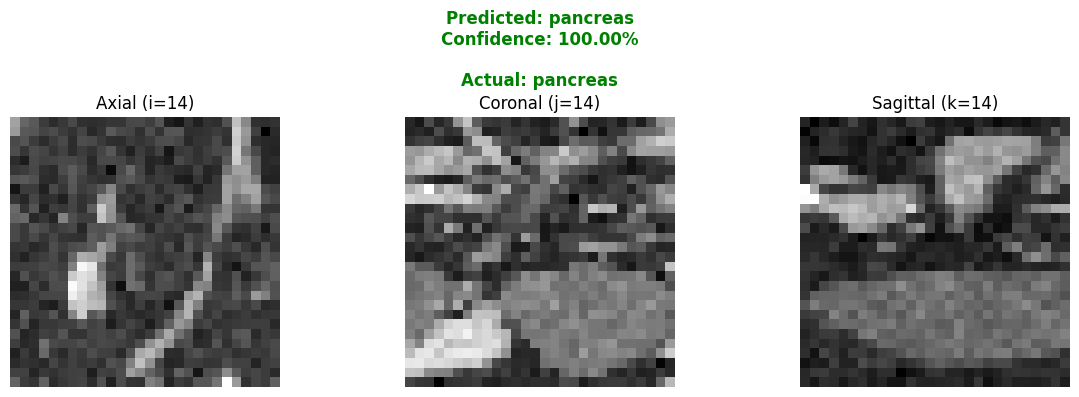

In [5]:
# Visualize predictions with confidence scores
def visualize_prediction(image_idx):
    """Show a test image with model prediction and confidence"""
    vol = np.squeeze(testx[image_idx], axis=0)
    
    # Get prediction
    img_tensor = tf.expand_dims(testx_tensor[image_idx], axis=0)
    prediction = model.predict(img_tensor, verbose=0)
    pred_class = np.argmax(prediction[0])
    confidence = prediction[0][pred_class]
    true_class = int(np.asarray(testy[image_idx]).squeeze())
    
    # Show middle slices
    i_mid = vol.shape[0] // 2
    j_mid = vol.shape[1] // 2
    k_mid = vol.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(vol[i_mid, :, :], cmap='gray')
    axes[0].set_title(f'Axial (i={i_mid})')
    axes[0].axis('off')
    
    axes[1].imshow(vol[:, j_mid, :], cmap='gray')
    axes[1].set_title(f'Coronal (j={j_mid})')
    axes[1].axis('off')
    
    axes[2].imshow(vol[:, :, k_mid], cmap='gray')
    axes[2].set_title(f'Sagittal (k={k_mid})')
    axes[2].axis('off')
    
    # Add prediction info
    pred_text = f"Predicted: {class_names[pred_class]}\nConfidence: {confidence:.2%}\n\nActual: {class_names[true_class]}"
    color = 'green' if pred_class == true_class else 'red'
    fig.suptitle(pred_text, fontsize=12, color=color, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Try different image indices (0 to len(testx)-1)
visualize_prediction(0)

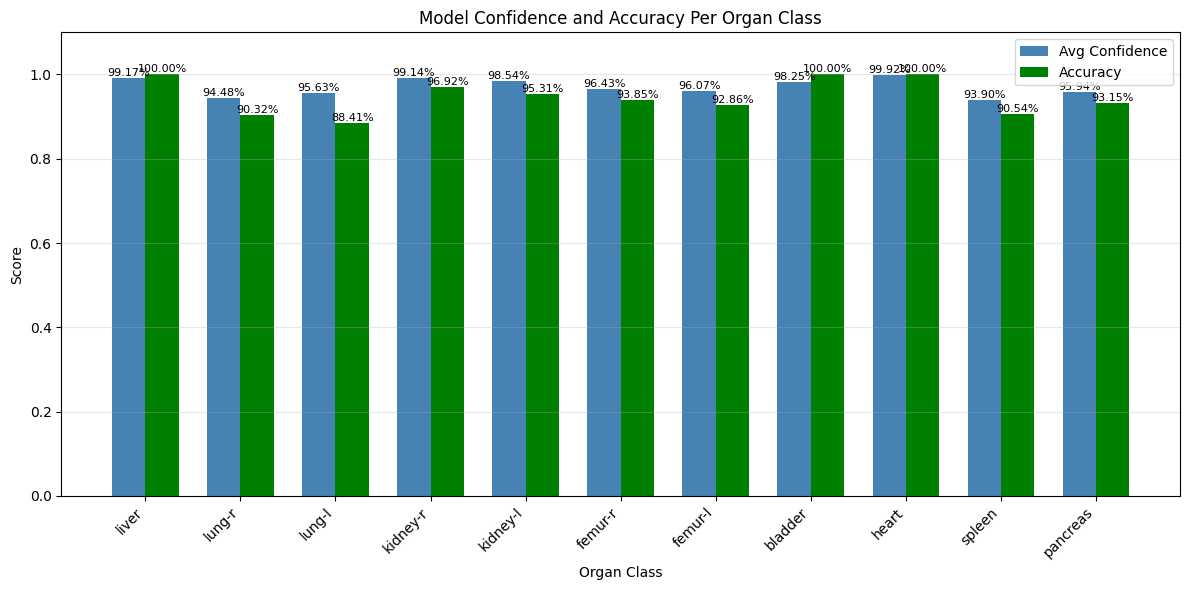

In [4]:
# Confidence per classification across entire test set
def show_confidence_per_class():
    """Show average confidence for each organ class"""
    class_confidences = {i: [] for i in range(len(class_names))}
    class_correct = {i: [] for i in range(len(class_names))}
    
    # Get predictions for all test images
    for idx in range(len(testx)):
        img_tensor = tf.expand_dims(testx_tensor[idx], axis=0)
        prediction = model.predict(img_tensor, verbose=0)[0]
        pred_class = np.argmax(prediction)
        confidence = prediction[pred_class]
        true_class = int(np.asarray(testy[idx]).squeeze())
        
        # Store confidence for predicted class
        class_confidences[pred_class].append(confidence)
        # Track if prediction was correct
        class_correct[pred_class].append(pred_class == true_class)
    
    # Calculate averages
    avg_confidences = []
    accuracy_per_class = []
    for i in range(len(class_names)):
        if class_confidences[i]:
            avg_confidences.append(np.mean(class_confidences[i]))
            accuracy_per_class.append(np.mean(class_correct[i]))
        else:
            avg_confidences.append(0)
            accuracy_per_class.append(0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, avg_confidences, width, label='Avg Confidence', color='steelblue')
    bars2 = ax.bar(x + width/2, accuracy_per_class, width, label='Accuracy', color='green')
    
    ax.set_xlabel('Organ Class')
    ax.set_ylabel('Score')
    ax.set_title('Model Confidence and Accuracy Per Organ Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2%}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

show_confidence_per_class()

In [11]:
# Test set accuracy summary
test_loss, test_acc = model.evaluate(testx_tensor, testy_tensor, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 93.93%
Test Loss: 0.1875
